<a href="https://colab.research.google.com/github/sakskap/sakskap.github.io/blob/main/Forecasting_Sales_KaggleCompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder


In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sakshamk","key":"8c84f910490b565ab550437f0b772cb5"}'}

In [7]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Places API token in the Kaggle directory 

In [8]:
! cp kaggle.json ~/.kaggle/

Changes permissions for directory

In [9]:
 ! chmod 600 ~/.kaggle/kaggle.json

Check if it all works

In [10]:
! kaggle datasets list

ref                                                  title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                   Data Science Job Salaries                    7KB  2022-06-15 08:59:12          20216        631  1.0              
deepcontractor/mcdonalds-india-menu-nutrition-facts  McDonald's India : Menu Nutrition Dataset    5KB  2022-07-28 17:08:52           1364         84  0.9411765        
gpreda/life-expectancy-in-europe-by-age-and-sex      Life Expectancy in Europe by Age and Sex     4MB  2022-08-12 15:28:01            508         28  1.0              
arianazmoudeh/airbnbopendata                         Airbnb Open Data                            10MB  2022-08-01 15:58:10            989         34  0.9705882 

In [11]:
!kaggle competitions download -c store-sales-time-series-forecasting

 23% 5.00M/21.4M [00:00<00:02, 6.94MB/s]
100% 21.4M/21.4M [00:00<00:00, 28.0MB/s]


In [12]:
!unzip store-sales-time-series-forecasting.zip

Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [13]:
!dir

holidays_events.csv  sample_submission.csv		      train.csv
kaggle.json	     store-sales-time-series-forecasting.zip  transactions.csv
oil.csv		     stores.csv
sample_data	     test.csv


In [14]:
holidays = pd.read_csv('holidays_events.csv', header = 0)

In [15]:
oil = pd.read_csv('oil.csv', header = 0)

In [16]:
stores = pd.read_csv('stores.csv', header = 0)
trans = pd.read_csv('transactions.csv', header = 0)
train = pd.read_csv('train.csv', header = 0)
test = pd.read_csv('test.csv', header = 0)


In [17]:
# converting date column in each dataset to DateTime format.
holidays['date'] = pd.to_datetime(holidays['date'], format = "%Y-%m-%d")
oil['date'] = pd.to_datetime(oil['date'], format = "%Y-%m-%d")
trans['date'] = pd.to_datetime(trans['date'], format = "%Y-%m-%d")
train['date'] = pd.to_datetime(train['date'], format = "%Y-%m-%d")
test['date'] = pd.to_datetime(test['date'], format = "%Y-%m-%d")

In [18]:
holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [19]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [20]:
trans

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [24]:
transD = holidays.transferred.value_counts() # geting the number of transferred holidays.
typeD = holidays.type.value_counts() # geting the number of each holiday type.
localeD = holidays.locale.value_counts() # geting the number of each holiday locale.

# plotting the data.
fig = make_subplots(rows=2, cols=3, specs=[[{"type": "pie"}, {"type": "pie"},{"type": "pie"}],
                          [{"colspan": 3},None,None] ],
                    vertical_spacing=0.1, horizontal_spacing=0.1,
                    subplot_titles=('Percentage of Transferred Holidays', 'Percentage of Holidays\' Typs',
                                    "Percentage of Holidays\' Lacale States" ,'Holidays\' Names'))

fig.append_trace(go.Pie(labels=transD.index, values=transD),
              row=1, col=1)

fig.add_trace(go.Pie(labels=typeD.index, values=typeD),
              row=1, col=2)

fig.add_trace(go.Pie(labels=localeD.index, values=localeD),
              row=1, col=3)

fig.add_trace(go.Histogram(x=holidays.locale_name),
              row=2, col=1)

fig.update_layout(height=1000,showlegend=False)
fig.show()

In [25]:
holidays = holidays[holidays.transferred == False][['date','type','locale','locale_name']][(holidays.date >= '2013-01-01')&(holidays.date <= '2017-08-31')]
holidays

,date,type,locale,locale_name
41,2013-01-01,Holiday,National,Ecuador
42,2013-01-05,Work Day,National,Ecuador
43,2013-01-12,Work Day,National,Ecuador
44,2013-02-11,Holiday,National,Ecuador
45,2013-02-12,Holiday,National,Ecuador
...,...,...,...,...
322,2017-07-25,Additional,Local,Guayaquil
323,2017-08-05,Holiday,Local,Esmeraldas
325,2017-08-11,Transfer,National,Ecuador
326,2017-08-15,Holiday,Local,Riobamba


In [26]:
fig = go.Figure([go.Scatter(x=oil['date'], y=oil['dcoilwtico'],marker=dict(color= '#783242'))])
fig.show()

In [27]:
oil = oil.set_index('date').fillna(method = 'bfill')
oil_moving_average = oil.rolling(
    window=365,       
    center=True,      
    min_periods=183,  
).mean()

fig = make_subplots(rows=1, cols=1, vertical_spacing=0.08)

fig.add_trace(go.Scatter(x=oil.index, y=oil['dcoilwtico'], mode='lines',
                     marker=dict(color= '#783242'), name='365-Day Oil Moving Average'))

fig.add_trace(go.Scatter(x=oil_moving_average.index,y=oil_moving_average.dcoilwtico,mode='lines',name='Trend'))

fig.show()

Exploring seasonlity in oil data

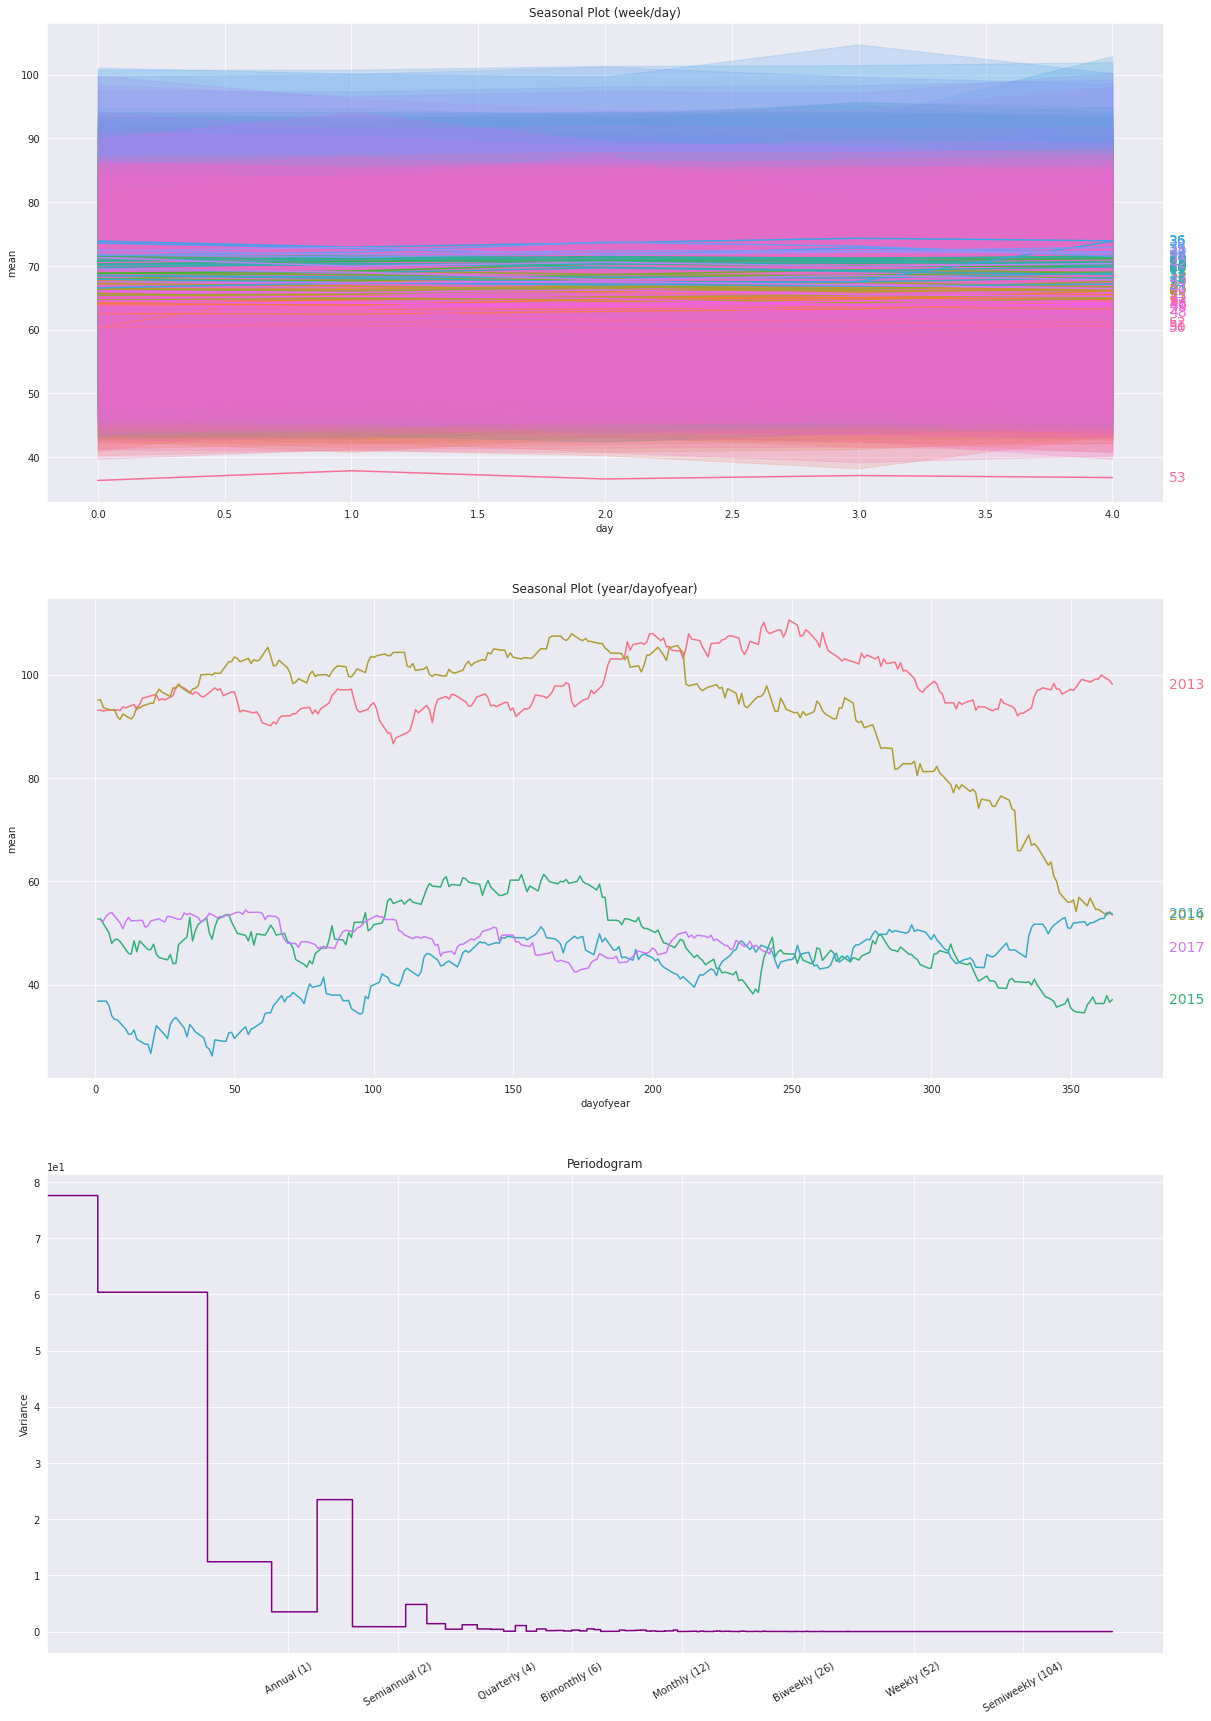

In [28]:
def grouped(df, key, freq, col):
    """ GROUP DATA WITH CERTAIN FREQUENCY """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(x=X[freq], 
                      y=X[y],
                      ax=ax, 
                      hue=X[period],
                      palette=palette, 
                      legend=False)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, 
                    xy=(1, y_), 
                    xytext=(6, 0), 
                    color=line.get_color(), 
                    xycoords=ax.get_yaxis_transform(), 
                    textcoords="offset points", 
                    size=14, 
                    va="center")
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", 
                        "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", 
                        "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

def seasonality(df, key, freq, col):
    df_grouped = grouped(df, key, freq, col)
    df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d")
    df_grouped.index = df_grouped['date'] 
    df_grouped = df_grouped.drop(columns=['date'])
    df_grouped.index.freq = freq # manually set the frequency of the index
    
    X = df_grouped.copy()
    X.index = pd.to_datetime(X.index, format = "%Y-%m-%d") 
    X.index.freq = freq 
    # days within a week
    X["day"] = X.index.dayofweek   # the x-axis (freq)
    X["week"] = pd.Int64Index(X.index.isocalendar().week)  # the seasonal period (period)
    # days within a year
    X["dayofyear"] = X.index.dayofyear
    X["year"] = X.index.year
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 30))
    seasonal_plot(X, y='mean', period="week", freq="day", ax=ax0)
    seasonal_plot(X, y='mean', period="year", freq="dayofyear", ax=ax1)
    X_new = (X['mean'].copy()).dropna()
    plot_periodogram(X_new, ax=ax2)
    
seasonality(oil.reset_index(), 'date', 'D', 'dcoilwtico')

In [29]:
# plotting transactions data.
trans_date = trans.drop('store_nbr',axis=1).groupby('date').mean()
store_nbr_trans = trans.drop('date',axis=1).groupby('store_nbr').mean()

trans_date_moving_average = trans_date.rolling(
    window=365,       
    center=True,      
    min_periods=183,  
).mean()

fig = make_subplots(rows=2, cols=1, vertical_spacing=0.09,subplot_titles=('Transactions Moving Average','Average Store Transactions'))

fig.add_trace(go.Scatter(x=trans_date.index, y=trans_date['transactions'], mode='lines',
              marker=dict(color= '#1fdbb9')),
              row=1, col=1)

fig.add_trace(go.Scatter(x=trans_date_moving_average.index,y=trans_date_moving_average.transactions,mode='lines',marker=dict(color= '#067863'),name='Trend'),
              row=1, col=1)

fig.add_trace(go.Bar(x=store_nbr_trans.index, y=store_nbr_trans.transactions),
              row=2, col=1)

fig.update_layout(height=800,showlegend=False)

fig.show()

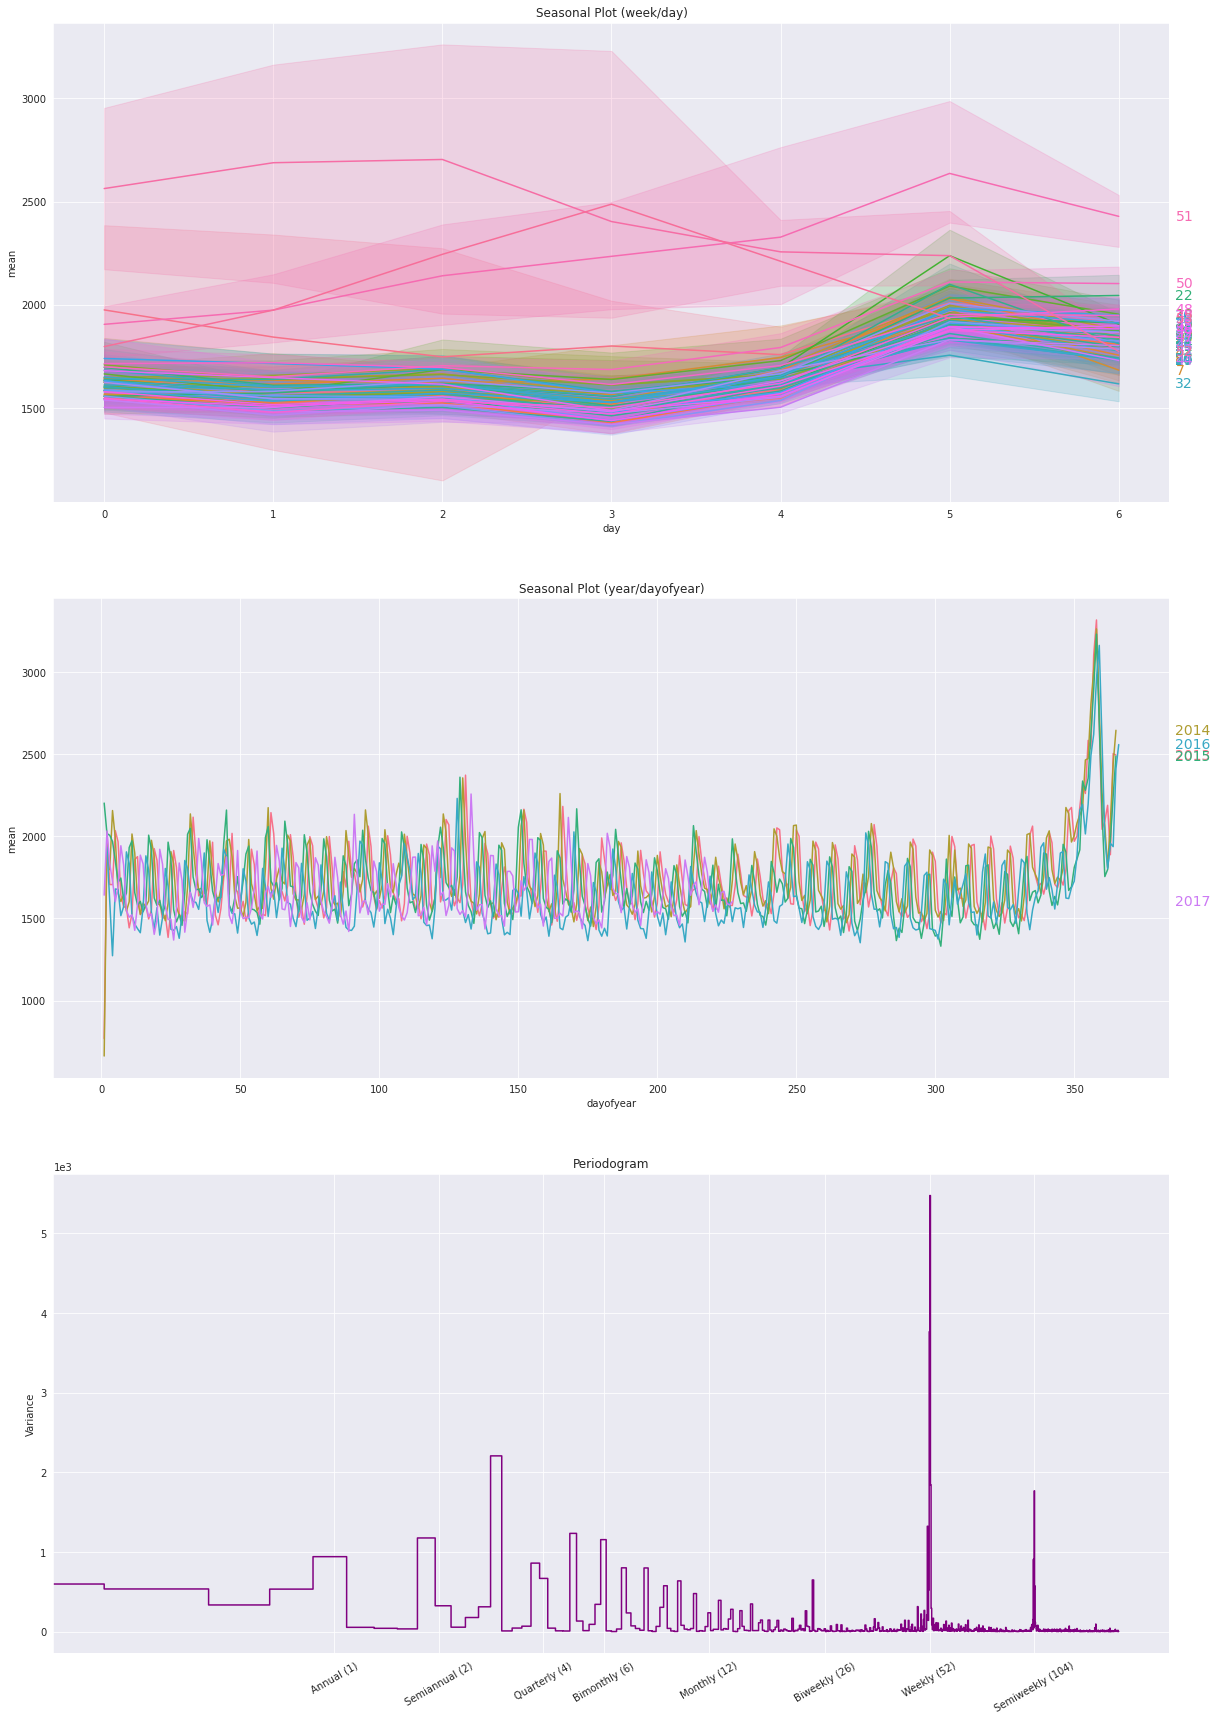

In [30]:
seasonality(trans, 'date', 'D', 'transactions')

In [31]:
train_modi = train.drop('id',axis=1) # droping the ID column.

# identifying holidays dates.
train_modi['holiday'] = 0
for date in holidays.date:
    train_modi['holiday'][train_modi.date == date] = 1
    
train_modi = pd.merge(train_modi, oil, how='left', on = 'date') # joining oil data.
train_modi = pd.merge(train_modi, trans, how='left', on = ['date','store_nbr']) # joining transactions data.

train_modi.drop(['store_nbr','family'],axis=1,inplace=True) # droping unnecessary columns.

train_modi = train_modi.groupby('date').mean() # grouping by date.
train_modi.fillna(method = 'bfill',inplace=True) # filling nan values.
train_modi

,sales,onpromotion,holiday,dcoilwtico,transactions
date,,,,,
2013-01-01,1.41,0.00,1.00,93.14,770.00
2013-01-02,278.39,0.00,0.00,93.14,2026.41
2013-01-03,202.84,0.00,0.00,92.97,1706.61
2013-01-04,198.91,0.00,0.00,93.12,1706.39
2013-01-05,267.87,0.00,1.00,93.20,2034.20
...,...,...,...,...,...
2017-08-11,463.73,7.96,1.00,48.81,1658.35
2017-08-12,444.80,4.66,0.00,47.59,1665.31
2017-08-13,485.77,5.21,0.00,47.59,1592.46


In [32]:
train_sales = train_modi.sales # sales data.
store_sales = train[['store_nbr','sales']].groupby('store_nbr').mean() # getting the average sales for each store.
family_sales = train[['family','sales']].groupby('family').mean() # getting the average sales for each family.
family_onpromotions = train[['family','onpromotion']].groupby('family').mean() #  getting the average promotion for each family.

# plotting.
train_sales_moving_average = train_sales.rolling(
    window=365,       
    center=True,      
    min_periods=183,  
).mean()

fig = make_subplots(rows=4, cols=1, vertical_spacing=0.09,
                    subplot_titles=('Sales Moving Average', 'Store Sales',
                                    "Family Sales" ,'Family Onpromotions'))

fig.add_trace(go.Scatter(x=train_sales.index, y=train_sales, mode='lines',
              marker=dict(color= '#dbd623')),
              row=1, col=1)

fig.add_trace(go.Scatter(x=train_sales_moving_average.index,y=train_sales_moving_average,mode='lines',marker=dict(color= '#eb8328'),name='Trend'),
              row=1, col=1)

fig.add_trace(go.Bar(x=store_sales.index, y=store_sales.sales),
              row=2, col=1)

fig.add_trace(go.Bar(x=family_sales.index, y=family_sales.sales),
              row=3, col=1)

fig.add_trace(go.Bar(x=family_onpromotions.index, y=family_onpromotions.onpromotion),
              row=4, col=1)

fig.update_layout(height=1750,showlegend=False)

fig.show()

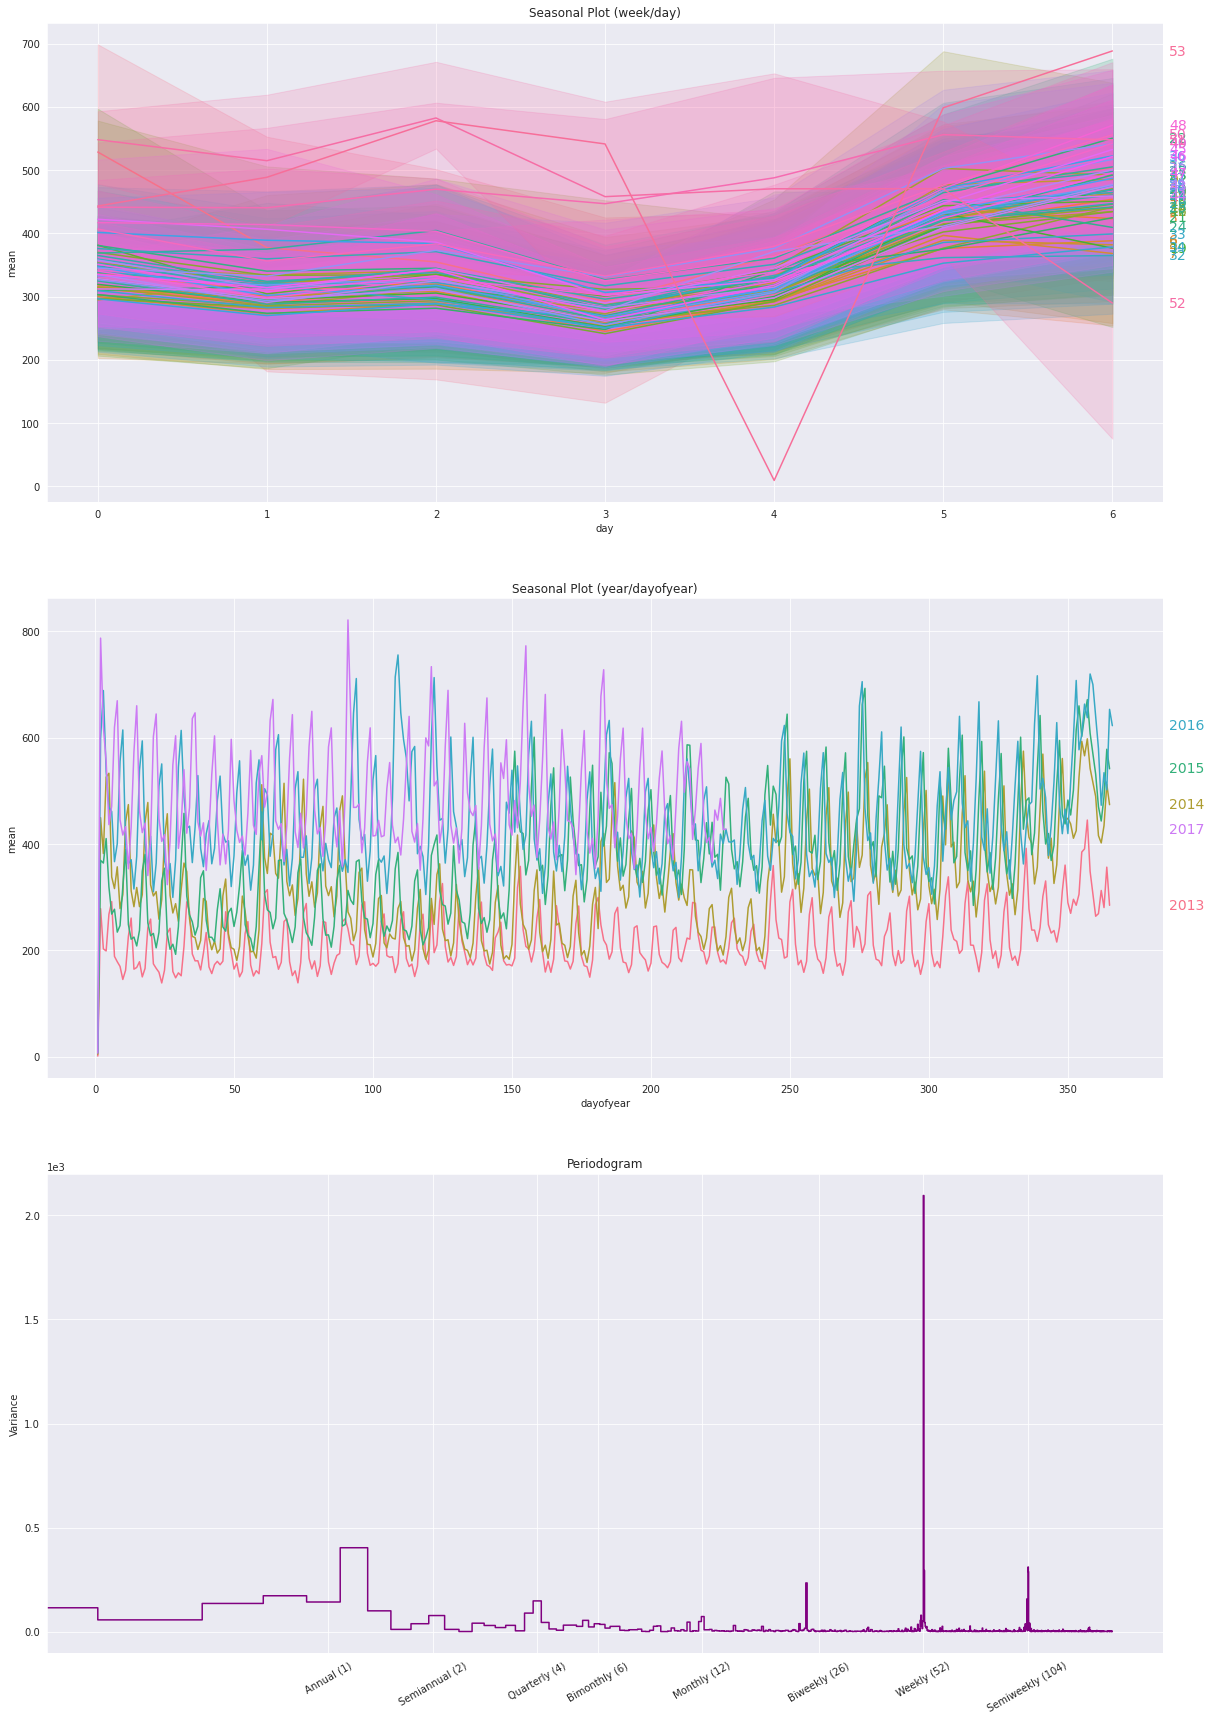

In [33]:
seasonality(train_modi.reset_index(), 'date', 'D', 'sales')

Train Data Correlations


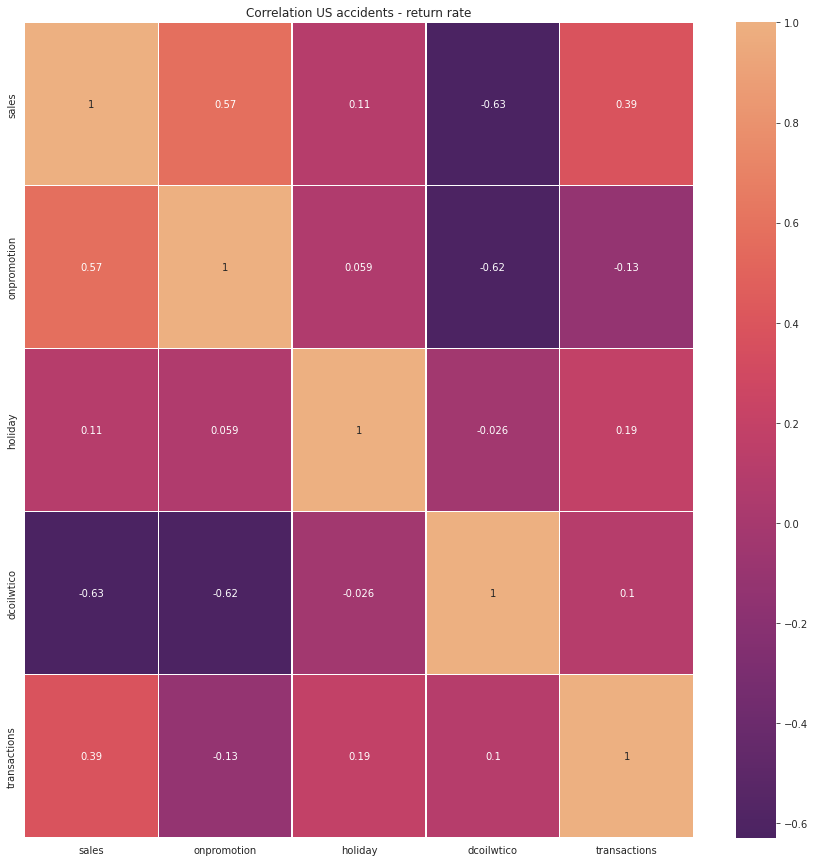

In [34]:

plt.figure(figsize=(15, 15))
sns.heatmap(train_modi.corr(), annot=True, cmap="flare_r", linewidths=0.1, annot_kws={"fontsize":10})
plt.title("Correlation US accidents - return rate");

In [35]:
full_data = pd.concat([train, test]).drop('id',axis=1)

full_data['holiday'] = 0
for date in holidays.date:
    full_data['holiday'][full_data.date == date] = 1
    
full_data = pd.merge(full_data, oil, how='left', on = 'date')

full_data['year'] = full_data.date.dt.year
full_data['month'] = full_data.date.dt.month
full_data['monthday'] = full_data.date.dt.day
full_data['weekday'] = full_data.date.dt.dayofweek

train = full_data.iloc[:len(train),:] 
test = full_data.iloc[len(train):,:] 

In [36]:
train.dropna(axis=0,subset = ['sales'], inplace = True) # droping null values from target.

X_train_full = train.drop(['sales'], axis =1)
y_train_full = train.sales

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,y_train_full,test_size=0.2, random_state=42) # spliting the data.

In [37]:
# A categorical transformer.
cat_trans = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'most_frequent')),
    ('ohe',OneHotEncoder(handle_unknown = 'ignore'))
])

# A preprocessor that combines the two previous transformers.
preprocessor = ColumnTransformer(transformers = [
    ('cat', cat_trans, ['family'])
],
    remainder = "drop")

X_train_trans = preprocessor.fit_transform(X_train).toarray()
X_valid_trans = preprocessor.transform(X_valid).toarray()

In [38]:
LR_model = LinearRegression() # creating linear regression model.

LR_model.fit(X_train_trans, y_train) # fitting the model with the training data.
preds_LR = LR_model.predict(X_valid_trans) # predict the target.

mean_absolute_error(y_valid, preds_LR) # geting the mean absolute error for predictions.


240.33795402100023

In [39]:
# preprocessing whole train and test data.
train_trans = preprocessor.fit_transform(X_train_full).toarray()
test_trans = preprocessor.transform(test.drop('sales',axis=1)).toarray()

In [41]:
submission = pd.read_csv('sample_submission.csv') # reading the sample_submission dataset.


In [42]:
submission

,id,sales
0,3000888,0.00
1,3000889,0.00
2,3000890,0.00
3,3000891,0.00
4,3000892,0.00
...,...,...
28507,3029395,0.00
28508,3029396,0.00
28509,3029397,0.00
28510,3029398,0.00


In [43]:
preds_LR 

array([1073.21875 ,  710.40625 ,  343.171875, ...,  462.984375,
        462.984375,  154.828125])

In [44]:
submission['sales']=preds_LR

ValueError: ignored